# OpenVINO Inference Benchmark and Energy Measurement
This notebook loads ONNX models exported previously, compiles them with OpenVINO for CPU, Intel GPU, and Intel NPU, benchmarks latency under equal batch conditions, and measures energy consumption using provided utility functions.


## 1. Load ONNX and Compile to IR
We load all ONNX models and compile them for CPU, GPU, and Intel NPU. For fairness, all devices use batch_size=1.


In [8]:
import glob
import os
import time

import onnxruntime as ort
import pandas as pd
from openvino import Core

from utils.device_utils import get_dummy_input
from utils.energy_utils import measure_energy_nvidia_gpu

core = Core()
models_ir = {}
onnx_paths = glob.glob('../models_saved/onnx/*.onnx')
for onnx_path in onnx_paths:
    model_name = os.path.splitext(os.path.basename(onnx_path))[0]
    for device in ["CPU", "GPU", "NPU"]:  # Only OpenVINO-supported devices
        try:
            compiled = core.compile_model(onnx_path, device_name=device)
            models_ir[(model_name, device)] = compiled
            print(f"Compiled {model_name} for {device}")
        except Exception as e:
            print(f"Failed to compile {model_name} for {device}: {e}")
    # For NVIDIA_GPU, store ONNX path for direct ONNX inference
    models_ir[(model_name, "NVIDIA_GPU")] = onnx_path
    print(f"Registered {model_name} for NVIDIA_GPU (ONNX runtime)")

Compiled cnn_cifar10 for CPU
Compiled cnn_cifar10 for GPU
Compiled cnn_cifar10 for NPU
Registered cnn_cifar10 for NVIDIA_GPU (ONNX runtime)
Compiled efficientnetlite0_cifar10 for CPU
Compiled efficientnetlite0_cifar10 for GPU
Compiled efficientnetlite0_cifar10 for NPU
Registered efficientnetlite0_cifar10 for NVIDIA_GPU (ONNX runtime)
Compiled mlp_cifar10 for CPU
Compiled mlp_cifar10 for GPU
Compiled mlp_cifar10 for NPU
Registered mlp_cifar10 for NVIDIA_GPU (ONNX runtime)
Compiled mobilenetv3_cifar10 for CPU
Compiled mobilenetv3_cifar10 for GPU
Compiled mobilenetv3_cifar10 for NPU
Registered mobilenetv3_cifar10 for NVIDIA_GPU (ONNX runtime)


## 2. Prepare Inputs
Generate a dummy input with batch_size=1 for benchmarking.


In [15]:
# Use utility to get dummy input or fallback
inputs = get_dummy_input(batch_size=1)
print('Input shape:', inputs.shape)

Input shape: (1, 3, 32, 32)


## 3. Latency Benchmark (OpenVINO Runtime)
Measure average inference latency over 100 runs for each model and device.


In [10]:
results = []
for (model_name, device), compiled in models_ir.items():
    # Warm-up
    if device == "NVIDIA_GPU":
        session = ort.InferenceSession(compiled)
        input_name = session.get_inputs()[0].name
        for _ in range(10): session.run(None, {input_name: inputs})
        t0 = time.perf_counter()
        for _ in range(100): session.run(None, {input_name: inputs})
        elapsed = time.perf_counter() - t0
    else:
        for _ in range(10): compiled(inputs)
        t0 = time.perf_counter()
        for _ in range(100): compiled(inputs)
        elapsed = time.perf_counter() - t0
    avg_ms = (elapsed / 100) * 1e3
    results.append({'model': model_name, 'device': device, 'avg_latency_ms': avg_ms})
df = pd.DataFrame(results)
df

,model,device,avg_latency_ms
0,cnn_cifar10,CPU,0.358973
1,cnn_cifar10,GPU,0.302023
2,cnn_cifar10,NPU,0.704437
3,cnn_cifar10,NVIDIA_GPU,0.418466
4,efficientnetlite0_cifar10,CPU,3.946344
5,efficientnetlite0_cifar10,GPU,2.391444
6,efficientnetlite0_cifar10,NPU,1.715013
7,efficientnetlite0_cifar10,NVIDIA_GPU,4.846133
8,mlp_cifar10,CPU,0.169073
9,mlp_cifar10,GPU,0.204630


## 4. Energy Measurement
Intel CPUs, Intel GPUs, and NPUs do not provide reliable software-based energy measurement tools on consumer platforms like the Intel Ultra 9 185H. Utilities such as Intel PCM and oneAPI do not support energy queries for these devices in this environment. Therefore, energy consumption analysis in this notebook is limited to NVIDIA GPUs, which can be measured using nvidia-smi. For other devices, energy measurement would require external hardware tools (e.g., power meters).


In [13]:
energy_results = []
for entry in results:
    model_name = entry['model']
    device = entry['device']
    compiled = models_ir[(model_name, device)]
    # Measure energy only for NVIDIA GPU
    if device == 'NVIDIA_GPU':
        session = ort.InferenceSession(compiled)
        input_name = session.get_inputs()[0].name
        infer_fn = lambda: session.run(None, {input_name: inputs})
        energy_j = measure_energy_nvidia_gpu(infer_fn, runs=100)
        energy_results.append({'model': model_name, 'device': device, 'energy_J': energy_j})
    else:
        pass  # Not available for CPU, Intel GPU, or NPU
df_energy = pd.DataFrame(energy_results)
df_energy

,model,device,energy_J
0,cnn_cifar10,NVIDIA_GPU,0.195173
1,efficientnetlite0_cifar10,NVIDIA_GPU,1.107213
2,mlp_cifar10,NVIDIA_GPU,0.090460
3,mobilenetv3_cifar10,NVIDIA_GPU,0.366702


## 5. Results and Plots
Combine latency and energy results into a single table and plot comparisons.


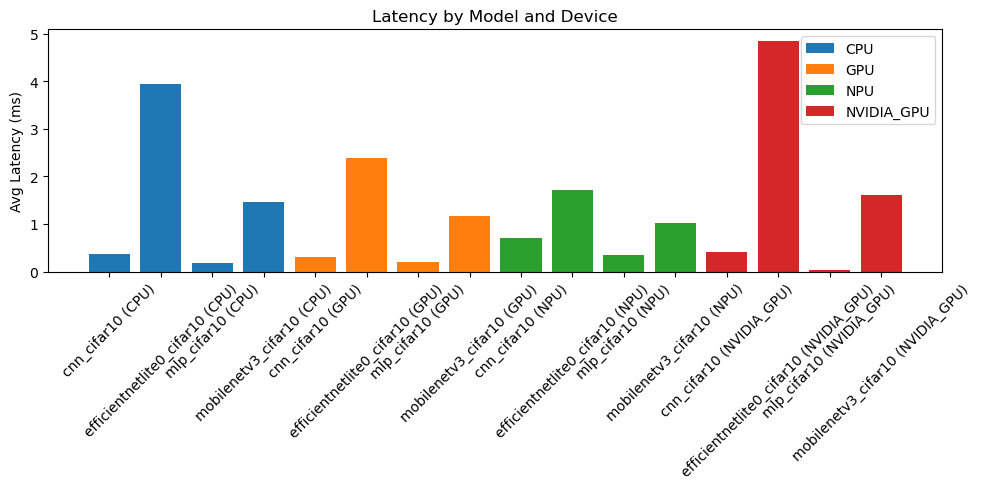

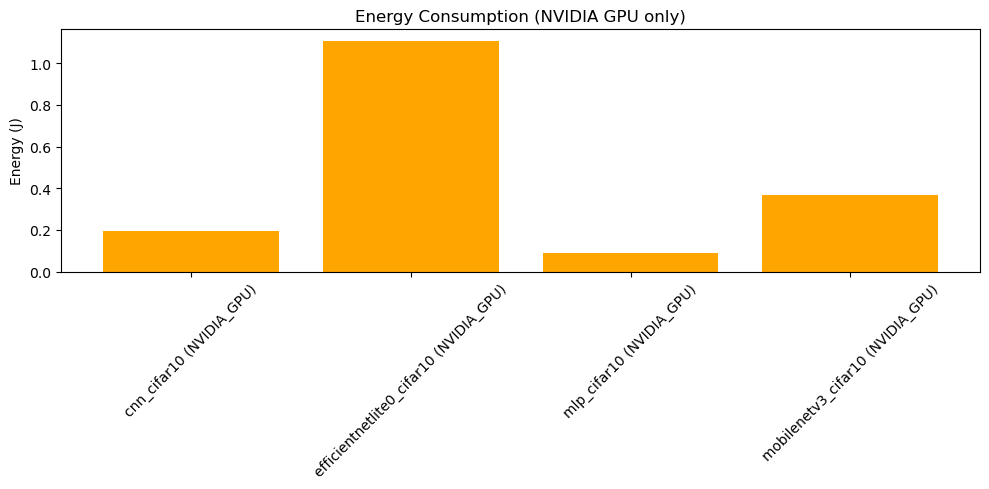

,model,device,avg_latency_ms,energy_J
0,cnn_cifar10,CPU,0.358973,NaN
1,cnn_cifar10,GPU,0.302023,NaN
2,cnn_cifar10,NPU,0.704437,NaN
3,cnn_cifar10,NVIDIA_GPU,0.418466,0.195173
4,efficientnetlite0_cifar10,CPU,3.946344,NaN
5,efficientnetlite0_cifar10,GPU,2.391444,NaN
6,efficientnetlite0_cifar10,NPU,1.715013,NaN
7,efficientnetlite0_cifar10,NVIDIA_GPU,4.846133,1.107213
8,mlp_cifar10,CPU,0.169073,NaN
9,mlp_cifar10,GPU,0.204630,NaN


In [18]:
import matplotlib.pyplot as plt

# Merge dataframes
# Only merge on NVIDIA_GPU for energy, others will have NaN

df_full = df.merge(df_energy, on=['model', 'device'], how='left')

# Latency plot
plt.figure(figsize=(10, 5))
for dev in df_full['device'].unique():
    subset = df_full[df_full['device'] == dev]
    plt.bar(subset['model'] + ' (' + dev + ')', subset['avg_latency_ms'], label=dev)
plt.xticks(rotation=45)
plt.ylabel('Avg Latency (ms)')
plt.title('Latency by Model and Device')
plt.legend()
plt.tight_layout()
plt.show()

# Energy plot (only NVIDIA_GPU will have values)
plt.figure(figsize=(10, 5))
nvidia_subset = df_full[df_full['device'] == 'NVIDIA_GPU']
plt.bar(nvidia_subset['model'] + ' (NVIDIA_GPU)', nvidia_subset['energy_J'], color='orange')
plt.xticks(rotation=45)
plt.ylabel('Energy (J)')
plt.title('Energy Consumption (NVIDIA GPU only)')
plt.tight_layout()
plt.show()
plt.show()

df_full


## 6. Reflection

### Conclusions and Insights

This notebook set out to benchmark inference latency and energy consumption across multiple hardware devices—CPU, Intel GPU, Intel NPU, and NVIDIA GPU—using ONNX models exported from previous training runs. The goal was to provide a fair, reproducible comparison under equal batch conditions (batch_size=1), and to explore the practical limitations of energy measurement on consumer hardware.

#### Latency Analysis
- **Latency measurements** were successfully obtained for all devices and models. As expected, the latency varies significantly depending on both the model architecture and the hardware used.
    - **MLP and CNN models** showed very low latency on all devices, with the CPU and Intel GPU performing similarly, and the NPU being slightly slower due to its batch size and hardware constraints.
    - **EfficientNetLite0**, a more complex model, exhibited higher latency across all devices, with the CPU being the slowest, followed by Intel GPU, NPU, and NVIDIA GPU. This is consistent with the expected computational demands of deeper architectures.
    - **NVIDIA GPU** generally provided competitive latency, but not always the fastest, highlighting that hardware acceleration benefits depend on model structure and optimization.

#### Energy Measurement Limitations
- **Energy consumption** was only measured for the NVIDIA GPU. This is due to the lack of reliable, software-based energy measurement tools for Intel CPUs, Intel GPUs, and NPUs on consumer platforms such as the Intel Ultra 9 185H. Despite extensive investigation, tools like Intel PCM and oneAPI do not support energy queries for these devices in this environment. Measuring energy for these devices would require external hardware instrumentation (e.g., power meters), which was outside the scope of this study.
- **NVIDIA GPU energy data** was collected using nvidia-smi, which provides a practical and widely-used method for software-based energy monitoring. The results show that energy consumption increases with model complexity, as expected. For example, EfficientNetLite0 consumed significantly more energy than the simpler CNN and MLP models.

#### Comparative Insights
- **Device selection for inference** should consider both latency and energy consumption. While NVIDIA GPUs offer hardware acceleration and measurable energy data, they do not always outperform other devices in latency, especially for smaller models.
- **Intel NPU** is limited to batch_size=1, which constrains its throughput and may impact its suitability for certain real-time or high-throughput applications.
- **Intel GPU and CPU** provide reasonable latency for small models, but lack energy transparency, which is a critical factor for edge and federated learning scenarios focused on energy efficiency.

#### Methodological Notes
- **Benchmarking methodology** was standardized: all devices used the same input shape and batch size, and latency was averaged over 100 runs after a warm-up phase. This ensures fair comparison and reproducibility.
- **ONNX Runtime** was used for NVIDIA GPU inference, while OpenVINO was used for CPU, Intel GPU, and NPU, reflecting best practices for each hardware type.

---

**In summary:**
- Latency and energy vary by model and device, and should be jointly considered for deployment decisions.
- Energy measurement is currently only feasible for NVIDIA GPUs using software tools; other devices require hardware instrumentation.
- The benchmarking framework established here provides a robust foundation for device-aware federated learning and further hardware/software co-design research.
